In [1]:
import csv
import pandas as pd
import math
import json
import numpy as np
import random
import matplotlib as plt
import re

#### 从国泰安下载和处理欺诈数据:公司研究系列-> 审计信息-> 违规信息-> 上市公司财务违规表，1265条，2000/1/1 ~ 2022/12/31
AR_FINVIOLATION_raw.xlsx -> AR_FINVIOLATION.csv ->  AR_FINVIOLATION_since2003.csv 细节在feature_process.ipynb里面

In [2]:
# weigui = pd.read_csv('../data/上市公司财务违规表/AR_FINVIOLATION.csv',encoding="gb18030")
weigui = pd.read_csv('../data/上市公司财务违规表/AR_FINVIOLATION_since2003.csv',encoding="gb18030")
print('共有 %d 家违规公司' % len(set(weigui['Symbol'])))
print('共有{}项违规文件'.format(weigui.shape))

共有 782 家违规公司
共有(1201, 5)项违规文件


##### 会计信息质量-财务指标里有总资产，所以不用再读取FS_Combas.csv
basic_info 亟待更新，因为里面的财务指标只到2021年，22年的财务指标要等23年4月30日全部上市公司都披露财报以后才行

In [3]:
# 本来用 all_corp_fin_data，但后来 all_corp_fin_data 更新了，里面没有金融类的公司了，就用更原始的 AIQ_LCFinIndexY.xlsx
# basic_info = pd.read_excel('../data/会计信息质量-财务指标/all_corp_fin_data.xlsx',encoding='gb18030')
basic_info = pd.read_excel('../data/会计信息质量-财务指标/AIQ_LCFinIndexY.xlsx',encoding='gb18030')
FS_combas = basic_info.loc[:,['Symbol','ShortName','EndDate','TotalAssets','Industry']].set_index(['Symbol','EndDate'])
FS_combas

ShortName   TotalAssets Industry
Symbol EndDate                                 
1      2000         深发展A  6.722750e+10       金融
       2001         深发展A  1.201270e+11       金融
       2002         深发展A  1.661664e+11       金融
       2003         深发展A  1.928510e+11       金融
       2004         深发展A  2.042864e+11       金融
...                  ...           ...      ...
900957 2017         凌云B股  1.019428e+09      房地产
       2018         凌云B股  1.007002e+09      房地产
       2019         凌云B股  1.017715e+09      房地产
       2020         凌云B股  1.008562e+09      房地产
       2021         凌云B股  1.023537e+09      房地产

[52574 rows x 3 columns]

P2501=虚构利润 (Fictitious Profit)；\
P2502=虚列资产 (Fictitious Assets)；\
P2503=虚假记载(误导性陈述) (False Recordation (Misleading Statements))；\
P2504=推迟披露 (Delayed Disclosure)；\
P2505=重大遗漏 (Material Omission)；\
P2506=披露不实(其它) (Other False Information Disclosure)；\
P2507=欺诈上市 (Fraudulent Listing)；\
P2508=出资违规 (False Capital Contribution)；\
P2509=擅自改变资金用途 (Unauthorized Changes in Capital Usage)；\
P2510=占用公司资产 (Occupancy of Company’s Assets)；\
P2511=内幕交易 (Insider Trading)；\
P2512=违规买卖股票 (Illegal Stock Trading)；\
P2513=操纵股价 (Stock Price Manipulation)；\
P2514=违规担保 (Illegal Guarantee)；\
P2515=一般会计处理不当 (Mishandling of General Accounting)；\
P2599=其他 (Others)

财务舞弊的类别采用Wang Gang 22年 DSS论文里的P2501-P2506 (虚构利润、虚列资产、虚假记载(误导性陈述)、推迟披露、重大遗漏、披露不实(其它))，其中 虚构利润、虚列资产 是最严格的财务舞弊(参见《上市公司财务舞弊识别模型设计及其应用研究》)

In [20]:
firm_year_type = {}
firm_year_asset = {}

'''统计各筛选阶段中的淘汰公司数量'''
n_fraud_without_time, n_corp_without_ind, n_fincorp, n_corp_fraud = [], [], [], []

print('最开始共有 %d 家违规公司' % len(set(weigui['Symbol'])))

for i in range(weigui.shape[0]):
    stkID = weigui.loc[i,'Symbol']
    if weigui.loc[i,'ViolationYear'] is not np.nan:
        n_fraud_without_time.append(stkID)
        
        vio_years = json.loads(weigui.loc[i,'ViolationYear'])
        '''# 排除最晚1999年以前的造假
        if vio_years[-1] > 1999:
            # 保留2000年以来的造假
            vio_years = [j for j in vio_years if j > 1999]'''
        for year in vio_years:
            if (stkID, year) in FS_combas.index:
                n_corp_without_ind.append(stkID)
                # 获取行业
                ind = FS_combas.loc[(stkID,year),'Industry']
                #  排除行业类型为金融的，ST 或者 PT暂时先不判断
                # if judge_ST_PT(stkID,year) is True
                if '金融' not in ind:
                    n_fincorp.append(stkID)

                    weiguiType = re.findall(
                        r'P25[0-9][0-9]', str(weigui.loc[i,'ViolationType'])
                    )
                    if 'P2501' in weiguiType or 'P2502' in weiguiType or 'P2503' in weiguiType or 'P2505' in weiguiType or 'P2506' in weiguiType or 'P2504' in weiguiType:
                    # if 'P2501' in weiguiType or 'P2502' in weiguiType:
                        # 虚构利润、虚列资产、虚假记载(误导性陈述)、推迟披露、重大遗漏、披露不实(其它)
                        # 一般会计处理不当不作为财务舞弊的类别了，因为没有文献支撑
                        n_corp_fraud.append(stkID)
                        if stkID not in firm_year_type:
                            firm_year_type[stkID] = {}
                        if year in firm_year_type[stkID]:
                            # 将当前年份的违规类型合并到firm_year_type[stkID][year]中,
                            firm_year_type[stkID][year] = list(set(firm_year_type[stkID][year] + weiguiType))
                        else:
                            firm_year_type[stkID][year] = list(set(weiguiType))
                        firm_year_asset[(stkID, year)]= FS_combas.loc[(stkID, year),'TotalAssets']

print('共有 %d 家公司的 %d 项强制执行' % ( len(set(weigui.Symbol.tolist())), weigui.shape[0]))
print('共有 %d 家公司的强制执行有表明欺诈日期,剩下 %d 家公司的 %d 个强制执行没有日期' % (len(set(n_fraud_without_time)), len(set(weigui.Symbol)-set(n_fraud_without_time)), weigui.shape[0]-len(n_fraud_without_time)))
print('共有 %d 家公司有行业数据,剩下 %d 家公司没有行业数据' % (len(set(n_corp_without_ind)), len(set(n_fraud_without_time)-set(n_corp_without_ind))))
print('共有 %d 家违规非金融公司,剩下 %d 家公司为金融公司' % (len(set(n_fincorp)), len(set(n_corp_without_ind)-set(n_fincorp))))
print('共有 %d 家公司违规类是财务报表欺诈,剩下 %d 家公司没有发生财务报表欺诈' % (len(set(n_corp_fraud)), len(set(n_fincorp)-set(n_corp_fraud))))

最开始共有 782 家违规公司
共有 782 家公司的 1201 项强制执行
共有 761 家公司的强制执行有表明欺诈日期,剩下 21 家公司的 40 个强制执行没有日期
共有 756 家公司有行业数据,剩下 5 家公司没有行业数据
共有 751 家违规非金融公司,剩下 5 家公司为金融公司
共有 631 家公司违规类是财务报表欺诈,剩下 120 家公司没有发生财务报表欺诈


当 weigui="上市公司财务违规表/AR_FINVIOLATION.csv" 时:

最开始共有 815 家违规公司\
共有794次强制执行有表明欺诈日期,剩下21家公司的欺诈没有日期\
共有779家公司有行业数据,剩下15家公司没有行业数据\
共有775家违规非金融公司,剩下4家公司为金融公司\
共有654家公司违规类是财务报表欺诈,剩下121家公司没有发生财务报表欺诈\
*注意：15家没有行业和asset数据的公司，大多是因为其22年的年报还没有出来，因为22年的财报在23年4月30日之前才会出，而 basic_info 里面的财务指标和行业只到21年为止，如果要包含22年的公司，则要在23年4月30日以后返回来更新 basic_info*

In [48]:
# 筛选合格的上市公司,生成 frau_time_industry_money_XXXX.csv
frau_time_industry_money = pd.DataFrame(columns=['Stkcd','inc_name','fraud_year','industry','type','asset'], dtype=object)
for stkID in firm_year_type:
    for year in firm_year_type[stkID]:
        ind = FS_combas.loc[(stkID,year),'Industry']
        inc_name = FS_combas.loc[(stkID,year),'ShortName']
        # ensure_ascii=False 防止出现中文乱码
        weigui_type = json.dumps(sorted(firm_year_type[stkID][year]),ensure_ascii=False)
        asset = firm_year_asset[(stkID, year)]
        temp = pd.DataFrame({
            'Stkcd':str(stkID).zfill(6),
            'inc_name':inc_name,
            'fraud_year':year,
            'industry':ind,
            'type':weigui_type,
            'asset':asset
        },index=[0])
        frau_time_industry_money = frau_time_industry_money.append(temp,ignore_index=True)
# 如果有bug：TypeError: Cannot interpret '<attribute 'dtype' of 'numpy.generic' objects>' as a data type，就换一个环境跑，是pandas和numpy的问题

In [49]:
# frau_time_industry_money
# frau_time_industry_money.to_csv('../data/frau_time_industry_money_til2022.csv',index=None,encoding='gb18030')
frau_time_industry_money.to_csv('../data/frau_time_industry_money_since2003.csv',index=None,encoding='gb18030')

In [50]:
fraud_info = pd.read_csv('../data/frau_time_industry_money_since2003.csv',encoding='gb18030')
len(set(fraud_info.loc[:,'Stkcd']))
#fraud_info.head

631

##### 杜玮的本子需要，临时统计一下2000年1月1日到2022年12月31日的财务造假案件 (基于AR_FINVIOLATION.csv 而不是 AR_FINVIOLATION_since2003.csv)

In [43]:
import collections
proper_weigui = []
actions_by_year = collections.defaultdict(list)
weigui_by_year = collections.defaultdict(list)

for i in range(weigui.shape[0]):
    stkID = weigui.loc[i,'Symbol']
    report_year = int(weigui.loc[i,'DeclareDate'].split('-')[0])

    weiguiType = re.findall(
        r'P25[0-9][0-9]', str(weigui.loc[i,'ViolationType'])
    )
    if 'P2501' in weiguiType or 'P2502' in weiguiType or 'P2503' in weiguiType or 'P2505' in weiguiType or 'P2506' in weiguiType or 'P2504' in weiguiType:
        # 虚构利润、虚列资产、虚假记载(误导性陈述)、推迟披露、重大遗漏、披露不实(其它)
        # 一般会计处理不当不作为判断标准，因为缺乏文献支撑
        proper_weigui.append(stkID)
        actions_by_year[report_year].append(stkID)

        if weigui.loc[i,'ViolationYear'] is not np.nan:
            occur_years = json.loads(weigui.loc[i,'ViolationYear'])
            for y in occur_years:
                weigui_by_year[y].append(stkID)

print('据国泰安数据库中的上市公司财务违规数据表显示，自2000年1月1日至2022年12月31日，总共有%d起违规案件，其中财务欺诈的违规案件(enforcement actions)%d起，占比%f，\
共有%d家上市公司因虚构利润、虚列资产、虚假记载(误导性陈述)、推迟披露、重大遗漏或披露不实等原因发生过财务舞弊行为。' 
% (weigui.shape[0], len(proper_weigui),  len(proper_weigui)/weigui.shape[0], len(set(proper_weigui))))

据国泰安数据库中的上市公司财务违规数据表显示，自2000年1月1日至2022年12月31日，总共有1248起违规案件，其中财务欺诈的违规案件(enforcement actions)1016起，占比0.814103，共有688家上市公司因虚构利润、虚列资产、虚假记载(误导性陈述)、推迟披露、重大遗漏或披露不实的原因发生过违规行为。


观察各年份违规案件(enforcement actions)的发生频次情况，在2000年1月1日至2022年12月31日，每年报道的案件：
{2000: 5, 2001: 11, 2002: 8, 2003: 10, 2004: 19, 2005: 9, 2006: 5, 2007: 12, 2008: 9, 2009: 10, 2010: 13, 2011: 32, 2012: 41, 2013: 60, 2014: 56, 2015: 61, 2016: 65, 2017: 66, 2018: 60, 2019: 77, 2020: 107, 2021: 149, 2022: 131}


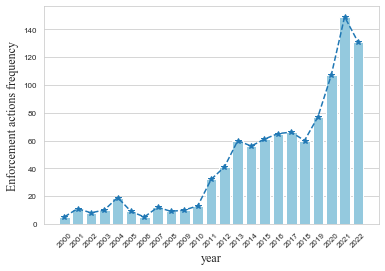

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
print('观察各年份违规案件(enforcement actions)的发生频次情况，在2000年1月1日至2022年12月31日，每年报道的案件：')
n_actions_by_year = {}
for y in sorted(actions_by_year.keys()):
    n_actions_by_year[y]=len(actions_by_year[y])
print(n_actions_by_year)

plt.rc('font', family='Times New Roman', size=8)
# 设置字体属性字典
fontdict = {'family': 'Times New Roman', 'size': 12}

x = sorted(n_actions_by_year.keys())
datas = pd.DataFrame({'x': x, 'y': [n_actions_by_year[key] for key in x]})
sns.set_style("whitegrid")
sns.barplot(x = 'x', y = 'y', data = datas, color = 'skyblue')
plt.plot([i for i in range(23)],datas['y'],'--*')
plt.xticks(rotation=45)
plt.xlabel("year",fontdict=fontdict)
plt.ylabel("Enforcement actions frequency",fontdict=fontdict)
# plt.title("",fontdict=fontdict)
plt.savefig("../data/违规案件频次.png", bbox_inches='tight', transparent=False, dpi=600, figsize=(50, 50))



In [45]:
TOTAL_FIRM_YEAR = 0
n_frauds_by_year = {}
for y in sorted(weigui_by_year.keys()):
    n_frauds_by_year[y] = len(set(weigui_by_year[y]))
    TOTAL_FIRM_YEAR += len(set(weigui_by_year[y]))
print('观察各违规公司-年份pair的发生频次情况，共有 %d 欺诈的公司-年份(firm-year)样本对，频次：'% TOTAL_FIRM_YEAR)
print(n_frauds_by_year)


观察各违规公司-年份pair的发生频次情况，共有 2348 欺诈的公司-年份(firm-year)样本对，频次：
{1992: 1, 1993: 2, 1994: 4, 1995: 6, 1996: 10, 1997: 17, 1998: 18, 1999: 20, 2000: 36, 2001: 42, 2002: 38, 2003: 35, 2004: 41, 2005: 32, 2006: 40, 2007: 60, 2008: 69, 2009: 90, 2010: 97, 2011: 139, 2012: 152, 2013: 137, 2014: 95, 2015: 131, 2016: 172, 2017: 197, 2018: 198, 2019: 177, 2020: 155, 2021: 103, 2022: 34}


#### 2023-02-15, 新添加一项欺诈公司筛选标准：排除财务造假后及时重述的样本

RestatementObject [重述对象] - 1=年报；2=中报；3=季报；4=三季报；5=审计报告；6=财务报告。\
RestatementYear [重述年度] - YYYY-MM-DD，财务重述错误期。\
DeclareDate [公告日期] - YYYY-MM-DD，财务重述披露期。\
ChangeDescription [变更描述] - 财务变更的概要性文字描述。\
RestatementType [重述类型] - 1=收入确认；2=成本计价；3=费用计价；4=资产=存货计价；5=企业并购；6=分立；7=证券相关；8=重分类问题；9=关联交易；10=会计政策变更；11=股票拆分；12=股票红利；13=其他\
ReasonDescription [原因说明] - 1=企业内部统计错误；2=法律或监管要求；3=媒体曝光或者是监管机构披露；4=审计机构统计错误；5=其他\
IsLag [是否滞后] - 0=当期；1=滞后。\
IsFinancialDataChange [是否涉及财务数据变更] - 1=是；0=否。

In [51]:
# 重述表的预处理在 feature_process.ipynb 里面
restate = pd.read_csv('../data/财务重述情况表/AR_FINRESTAT.csv',encoding='gb18030')
restate = restate.set_index(['Symbol','RestatementYear'],inplace=False)
fraud_info_by_id_year = fraud_info.set_index(['Stkcd','fraud_year'], inplace=False)

for stkcd, year in fraud_info_by_id_year.index:
    if (stkcd, year) in restate.index:
        r = restate.loc[(stkcd,year),:]
        if 1 in r.IsLag.tolist():
            # 判断是否有延期重述的，一旦有延期的，那么当前年就算做欺诈
            is_restate = False
        elif '法律或监管要求' in r.ReasonDescription.tolist() or '企业内部统计错误' in r.ReasonDescription.tolist():
            is_restate = False
            # 就算IsLag里面没有1，即不存在任何延迟的restate，有些 IsLag=0，实际也延了大半年，因此还要进一步来判断。
        else:
            # 可以再加一条筛选条件：年报的DeclareDate是否是在第二年的4-30以前，如果是的话，那就是真的没有延期restate。
            is_restate = True
    else:
        is_restate = False
    fraud_info_by_id_year.loc[(stkcd, year),'restate'] = is_restate
    
# fraud_info_by_id_year.to_csv('../data/frau_time_industry_money_til2022.csv',encoding='gb18030')
fraud_info_by_id_year.to_csv('../data/frau_time_industry_money_since2003.csv',encoding='gb18030')
# 存一个没有 restate 的fraud样本, 可能没什么用
# fraud_info_by_id_year[fraud_info_by_id_year.restate==False].to_csv('frau_time_no_restate.csv',encoding='gb18030')

In [92]:
# fraud_info = pd.read_csv('../data/frau_time_industry_money_til2022.csv',encoding='gb18030')
fraud_info = pd.read_csv('../data/frau_time_industry_money_since2003.csv',encoding='gb18030')

n_corrected_firm_year = len(set(fraud_info[fraud_info.restate==True].Stkcd.tolist()))
n_corrected_firm = len(set(fraud_info.Stkcd.tolist())) - len(set(fraud_info[fraud_info.restate==False].Stkcd.tolist()))

print('根据 上市公司财务重述情况表 ，我们识别出在季报或者半年报中发现财务造假，但在财年结束的年报公布前及时修正（restate）的公司样本，\
将其从财务造假的样本中剔除，总计有 %d 家公司和 %d 个公司-违规年份' % (n_corrected_firm, n_corrected_firm_year))
print('排除 restate 的样本后，共有{}家公司'.format(len(set(fraud_info[fraud_info.restate==False].Stkcd.tolist()))))

根据 上市公司财务重述情况表 ，我们识别出在季报或者半年报中发现财务造假，但在财年结束的年报公布前及时修正（restate）的公司样本，将其从财务造假的样本中剔除，总计有 6 家公司和 91 个公司-违规年份
排除 restate 的样本后，共有625家公司


##### 欺诈公司的数据筛选告一段落，
如果 weigui = AR_FINVIOLATION_since2003.csv，现在还剩有 625 家欺诈公司。\
如果用 weigui = AR_FINVIOLATION.csv，现在还剩有 649 家欺诈公司。\
后面还要根据非欺诈的公司进一步筛选欺诈公司

##### 2023年2月25日，用 frau_time_industry_money_til2022 生成 fraud_series_v0 和 fraud_series_net_v0，train_test_x1.csv 是基于现在的 fraud_series_net_v0 生成的

进一步为欺诈公司标明欺诈年份是否有财务指标、非财务指标、MDA数据

In [54]:
'''fin_ratios = pd.read_excel('../data/会计信息质量-财务指标/all_corp_fin_data.xlsx',encoding='gb18030')
fin_ratios.set_index(['Symbol','EndDate'], inplace=True)
nonfin_ratios = pd.read_csv('../data/非财务指标/nonfin_data_v2.csv',encoding='gb18030')
nonfin_ratios.set_index(['Symbol','year'], inplace = True)
mda = pd.read_excel('../data/年报/管理层讨论与分析/mda_no_number.xlsx',encoding='gb18030')
mda.set_index(['Scode','Year'], inplace=True)'''

在生成 fraud_series.csv 应该把所有 financial data、non financial data 和 linguistic features 都处理好，包括去除缺失的年份和补齐所有指标

In [70]:
'''
# fraud_firm_series = pd.DataFrame(columns=['Stkcd','year','is_fraud','AQI','AT','CFED','DSIR','DEPI','GMI','IG','LEV','OPM','RG','SG','SGEE'], dtype=object)
fraud_firm_series = pd.DataFrame(columns=['Stkcd','year','is_fraud','has_fin_ratios','has_nonfin_ratios','has_mda'], dtype=object)
fraud_firm_series = fraud_firm_series.set_index(['Stkcd','year'])
fraud_info = pd.read_csv('../data/frau_time_industry_money_til2022.csv',encoding='gb18030')

MAX_INTERVAL = 5 # 最多往前推 5 期

# 生成欺诈年份以前的非欺诈年份的序列
def generate_time_series(list1, MAX_INTERVAL):
    # 从欺诈年份往前数至多5年的数据
    list2 = [(list1[0],True)]
    for i in range(len(list1)-1):
        interval = (list1[i] - list1[i+1])
        fill_size = 0
        if interval == 1:
            list2.append((list1[i+1],True))
            continue
        else:
            if interval >= MAX_INTERVAL:
                fill_size = MAX_INTERVAL
            else:
                # 0 < interval < MAX_INTERVAL
                fill_size = interval
            for j in range(fill_size-1):
                list2.append((list1[i]- j-1, False))
            return list2
    
    for i in range(MAX_INTERVAL):
        list2.append((list1[-1]-i-1,False))
    return list2

def add_row(symbol, year_fraud_list):
    for year, is_fraud in year_fraud_list:
        fraud_firm_series.loc[(symbol,year),'is_fraud'] = is_fraud

        # 判断是否有齐全的 financial ratios
        if (symbol,year) in fin_ratios.index:
            # data = fin_ratios.loc[(symbol,year),['AQI','AT','CFED','DSIR','DEPI','GMI','IG','LEV','OPM','RG','SG','SGEE']]
            fraud_firm_series.loc[(symbol,year),'has_fin_ratios'] = True
        else:
            fraud_firm_series.loc[(symbol,year), 'has_fin_ratios'] = False
            
        # 判断是否有齐全的 nonfinancial ratios
        if (symbol, year) in nonfin_ratios.index:
            fraud_firm_series.loc[(symbol,year),'has_nonfin_ratios'] = True
        else:
            fraud_firm_series.loc[(symbol,year), 'has_nonfin_ratios'] = False
            
        # 判断是否有齐全的 Linguistic Features
        if (symbol, year ) in mda.index:
            fraud_firm_series.loc[(symbol,year),'has_mda'] = True
        else:
            fraud_firm_series.loc[(symbol,year),'has_mda'] = False

        # fraud_firm_series.loc[(symbol,year),['AQI','AT','CFED','DSIR','DEPI','GMI','IG','LEV','OPM','RG','SG','SGEE']] = data
        # [d for d in data if d is not np.nan and d != '#DIV/0!']
    return 0

years = []
pre_sym = fraud_info.loc[0,'Stkcd']

for i in range(fraud_info.shape[0]):
    symbol = fraud_info.loc[i,'Stkcd']
    year = fraud_info.loc[i,'fraud_year']
    restate = fraud_info.loc[i,'restate']
    if restate == True:
        continue
    if symbol == pre_sym:
        years.append(year)
    else:
        year_fraud = generate_time_series(sorted(years,reverse=True), MAX_INTERVAL)
        add_row(pre_sym, year_fraud)
        # 更新，开始下一家公司
        pre_sym = symbol
        years = [year]
    
    if i+1 == fraud_info.shape[0]: # 最后一行
        year_fraud = generate_time_series(sorted(years,reverse=True), MAX_INTERVAL)
        add_row(pre_sym, year_fraud)

fraud_firm_series.to_csv('../data/fraud_series_v0.csv', encoding='utf-8')'''

生成的 fraud_firm_series 是包含00, 01, 02年的 fraud-year，所有的欺诈、非欺诈年份最早的年份到1995年。

In [4]:
fraud_firm_series = pd.read_csv('../data/fraud_series_v0.csv', encoding='utf-8')
fraud_firm_series

,Stkcd,year,is_fraud,has_fin_ratios,has_nonfin_ratios,has_mda
0,4,2013,True,True,True,True
1,4,2012,True,True,True,True
2,4,2011,True,True,True,True
3,4,2010,True,True,True,True
4,4,2009,False,True,True,True
...,...,...,...,...,...,...
4699,688586,2019,False,False,False,False
4700,688586,2018,False,False,False,False
4701,688586,2017,False,False,False,False
4702,688586,2016,False,False,False,False


In [3]:
# fraud_series_v0.csv -> fraud_series_net_v0.csv：把缺少财务指标、非财务指标、和 linguistic features 的公司去了
'''from pandas import isnull
fraud_firm_series = pd.read_csv('../data/fraud_series_v0.csv', encoding='utf-8')
print('初始:共有%d家公司' % len(set(fraud_firm_series.Stkcd)))
# 先把 2003 年以前的删掉, 因为2003年以前没有关系数据

fraud_firm_series.set_index(['year'],inplace=True)

fraud_firm_series.drop([1995,1996,1997,1998,1999,2000,2001,2002],axis=0,inplace=True)
fraud_firm_series = fraud_firm_series.reset_index(drop = False)

# drop = True, 是否将原索引作为新的一列补进表格中
print('删完null的行以及2003年以前的行以后,剩%d家公司，被删的公司只有一行数据且都为null' % len(set(fraud_firm_series.Stkcd)))

#########################################################################################################################################################

# 再drop is_fraud 没有 false，全是 true 的公司, 然后drop 缺少财务指标、非财务指标、mda 的公司

# 统计每次筛选筛掉的公司数量,写进论文里
n_no_nonfraud_year, n_lack_findata, n_lack_nonfin, n_lack_mda = set(), set(), set(), set()
series_by_firm = fraud_firm_series.set_index(['Stkcd'])

for firm in set(series_by_firm.index):
    df = series_by_firm.loc[firm, :]
    if df.shape == (5,):
        # 只有一年的数据的公司，不构成时间序列
        n_no_nonfraud_year.add(firm)

    elif df.iloc[-1,1]==True:
        # 去掉没有非欺诈时间序列的公司
        n_no_nonfraud_year.add(firm)

    # elif df[(df.DSIR=='#DIV/0!')|(df.DEPI=='#DIV/0!')|(df.GMI=='#DIV/0!')|(df.IG=='#DIV/0!')|(df.RG=='#DIV/0!')].shape[0]>0:
    # elif df.isnull().sum().sum()>0:
    elif False in df.has_fin_ratios.tolist():
        # 去掉财务指标缺失值的公司
        # 在AIQ_LCFinIndexY_used.xlsx（excel）文件中，不存在“#DIV/0!”的值，取而代之的全部是空值。只有在csv文件中的才是“#DIV/0!”，所以这个条件判断没有用
        n_lack_findata.add(firm)
    
    elif False in df.has_nonfin_ratios.tolist():
        n_lack_nonfin.add(firm)
    
    elif False in df.has_mda.tolist():
        n_lack_nonfin.add(firm)


print('共有%d家没有非欺诈年份数据的公司或者只有一年的数据,剩下%d家公司有非欺诈年份数据' % (len(n_no_nonfraud_year), len(set(series_by_firm.index)-n_no_nonfraud_year)))
print('共有%d家公司缺失部分财务指标,有%d家公司缺失非财务指标,有%d家公司缺失 mda 数据,' % (len(n_lack_findata),len(n_lack_nonfin), len(n_lack_mda)))

print('剩下%d家公司财务指标完好' % len(set(series_by_firm.index)- n_no_nonfraud_year - n_lack_findata - n_lack_nonfin - n_lack_mda))
series_by_firm = series_by_firm.drop(
    n_no_nonfraud_year | n_lack_findata | n_lack_nonfin | n_lack_mda,
    axis=0,
)
'''

初始:共有649家公司
删完null的行以及2003年以前的行以后,剩625家公司，被删的公司只有一行数据且都为null
共有27家没有非欺诈年份数据的公司或者只有一年的数据,剩下598家公司有非欺诈年份数据
共有207家公司缺失部分财务指标,有13家公司缺失非财务指标,有0家公司缺失 mda 数据,
剩下378家公司财务指标完好


初始:共有649家公司\
删完null的行以及2003年以前的行以后,剩625家公司，被删的公司只有一行数据且都为null\
共有27家没有非欺诈年份数据的公司或者只有一年的数据,剩下598家公司有非欺诈年份数据\
共有207家公司缺失部分财务指标,有13家公司缺失非财务指标,有0家公司缺失 mda 数据,\
剩下378家公司财务指标完好

In [106]:
# fraud_series_net.csv：将
# 将行业、规模等数据补到series_by_firm上
# 总共有多少家公司
'''finRatio = pd.read_excel('../data/会计信息质量-财务指标/all_corp_fin_data.xlsx',encoding='gb18030').set_index(['Symbol','EndDate'])

series_by_firm = series_by_firm.reset_index(drop = False).set_index(['Stkcd','year'])
for firm,year in series_by_firm.index:
    # print(firm,year)
    series_by_firm.loc[(firm,year),'industry'] = finRatio.loc[(firm,year),'Industry']
    series_by_firm.loc[(firm,year),'asset'] = finRatio.loc[(firm,year),'TotalAssets']
series_by_firm.to_csv('../data/fraud_series_net.csv',encoding='gb18030')'''

In [5]:
series_by_firm  = pd.read_csv('../data/fraud_series_v0.csv',encoding='gb18030')
len(set(series_by_firm.Stkcd))

649

##### 2023年5月24日，用 frau_time_industry_money_since2003.csv 生成新的 fraud_series

In [5]:
fin_ratios = pd.read_excel('../data/会计信息质量-财务指标/findata_normalized.xlsx',encoding='gb18030')
fin_ratios.set_index(['Symbol','EndDate'], inplace=True)
nonfin_ratios = pd.read_csv('../data/非财务指标/nonfin_data_v2.csv',encoding='gb18030')
nonfin_ratios.set_index(['Symbol','year'], inplace = True)
mda = pd.read_excel('../data/年报/管理层讨论与分析/mda_no_number.xlsx',encoding='gb18030')
mda.set_index(['Scode','Year'], inplace=True)

In [10]:
# fraud_firm_series = pd.DataFrame(columns=['Stkcd','year','is_fraud','AQI','AT','CFED','DSIR','DEPI','GMI','IG','LEV','OPM','RG','SG','SGEE'], dtype=object)
fraud_firm_series = pd.DataFrame(columns=['Stkcd','year','is_fraud','has_fin_ratios','has_nonfin_ratios','has_mda'], dtype=object)
fraud_firm_series = fraud_firm_series.set_index(['Stkcd','year'])
fraud_info = pd.read_csv('../data/frau_time_industry_money_since2003.csv',encoding='gb18030')

MAX_INTERVAL = 5 # 最多往前推 5 期

# 生成欺诈年份以前的非欺诈年份的序列
def generate_time_series(list1, MAX_INTERVAL):
    # 从欺诈年份往前数至多5年的数据
    list2 = [(list1[0],True)]
    for i in range(len(list1)-1):
        interval = (list1[i] - list1[i+1])
        fill_size = 0
        if interval == 1:
            list2.append((list1[i+1],True))
            continue
        else:
            if interval >= MAX_INTERVAL:
                fill_size = MAX_INTERVAL
            else:
                # 0 < interval < MAX_INTERVAL
                fill_size = interval
            for j in range(fill_size-1):
                list2.append((list1[i]- j-1, False))
            return list2
    
    for i in range(MAX_INTERVAL):
        list2.append((list1[-1]-i-1,False))
    return list2

def add_row(symbol, year_fraud_list):
    for year, is_fraud in year_fraud_list:
        fraud_firm_series.loc[(symbol,year),'is_fraud'] = is_fraud

        # 判断是否有齐全的 financial ratios
        if (symbol,year) in fin_ratios.index:
            # data = fin_ratios.loc[(symbol,year),['AQI','AT','CFED','DSIR','DEPI','GMI','IG','LEV','OPM','RG','SG','SGEE']]
            fraud_firm_series.loc[(symbol,year),'has_fin_ratios'] = True
        else:
            fraud_firm_series.loc[(symbol,year), 'has_fin_ratios'] = False
            
        # 判断是否有齐全的 nonfinancial ratios
        if (symbol, year) in nonfin_ratios.index:
            fraud_firm_series.loc[(symbol,year),'has_nonfin_ratios'] = True
        else:
            fraud_firm_series.loc[(symbol,year), 'has_nonfin_ratios'] = False
            
        # 判断是否有齐全的 Linguistic Features
        if (symbol, year ) in mda.index:
            fraud_firm_series.loc[(symbol,year),'has_mda'] = True
        else:
            fraud_firm_series.loc[(symbol,year),'has_mda'] = False

        # fraud_firm_series.loc[(symbol,year),['AQI','AT','CFED','DSIR','DEPI','GMI','IG','LEV','OPM','RG','SG','SGEE']] = data
        # [d for d in data if d is not np.nan and d != '#DIV/0!']
    return 0

years = []
pre_sym = fraud_info.loc[0,'Stkcd']

for i in range(fraud_info.shape[0]):
    symbol = fraud_info.loc[i,'Stkcd']
    year = fraud_info.loc[i,'fraud_year']
    restate = fraud_info.loc[i,'restate']
    if restate == True:
        continue
    if symbol == pre_sym:
        years.append(year)
    else:
        year_fraud = generate_time_series(sorted(years,reverse=True), MAX_INTERVAL)
        add_row(pre_sym, year_fraud)
        # 更新，开始下一家公司
        pre_sym = symbol
        years = [year]
    
    if i+1 == fraud_info.shape[0]: # 最后一行
        year_fraud = generate_time_series(sorted(years,reverse=True), MAX_INTERVAL)
        add_row(pre_sym, year_fraud)

fraud_firm_series.to_csv('../data/fraud_series.csv', encoding='utf-8')

把新的 fraud_series.csv 重新生成 fraud_series_net.csv，要求新的 fraud_series_net 和老的 fraud_series_net_v0.csv 一样，都有378家公司

In [11]:
# fraud_series.csv -> fraud_series_net.csv：把缺少财务指标、非财务指标、和 linguistic features 的公司去了
from pandas import isnull

fraud_firm_series = pd.read_csv('../data/fraud_series.csv', encoding='utf-8')
print('初始:共有%d家公司' % len(set(fraud_firm_series.Stkcd)))
# 先把 2003 年以前的删掉, 因为2003年以前没有关系数据

fraud_firm_series.set_index(['year'],inplace=True)
fraud_firm_series.drop([1998,1999,2000,2001,2002],axis=0,inplace=True)
fraud_firm_series = fraud_firm_series.reset_index(drop = False)

# drop = True, 是否将原索引作为新的一列补进表格中
print('删完null的行以及2003年以前的行以后,剩%d家公司，被删的公司只有一行数据且都为null' % len(set(fraud_firm_series.Stkcd)))

#########################################################################################################################################################

# 再drop is_fraud 没有 false，全是 true 的公司, 然后drop 缺少财务指标、非财务指标、mda 的公司
'''统计每次筛选筛掉的公司数量,写进论文里'''
n_no_nonfraud_year, n_lack_findata, n_lack_nonfin, n_lack_mda = set(), set(), set(), set()
series_by_firm = fraud_firm_series.set_index(['Stkcd'])

for firm in set(series_by_firm.index):
    df = series_by_firm.loc[firm, :]
    if df.shape == (5,):
        # 只有一年的数据的公司，不构成时间序列
        n_no_nonfraud_year.add(firm)

    elif df.iloc[-1,1]==True:
        # 去掉没有非欺诈时间序列的公司
        n_no_nonfraud_year.add(firm)

    # elif df[(df.DSIR=='#DIV/0!')|(df.DEPI=='#DIV/0!')|(df.GMI=='#DIV/0!')|(df.IG=='#DIV/0!')|(df.RG=='#DIV/0!')].shape[0]>0:
    # elif df.isnull().sum().sum()>0:
    elif False in df.has_fin_ratios.tolist():
        # 去掉财务指标缺失值的公司
        # 在AIQ_LCFinIndexY_used.xlsx（excel）文件中，不存在“#DIV/0!”的值，取而代之的全部是空值。只有在csv文件中的才是“#DIV/0!”，所以这个条件判断没有用
        n_lack_findata.add(firm)
    
    elif False in df.has_nonfin_ratios.tolist():
        n_lack_nonfin.add(firm)
    
    elif False in df.has_mda.tolist():
        n_lack_nonfin.add(firm)


print('共有%d家没有非欺诈年份数据的公司或者只有一年的数据,剩下%d家公司有非欺诈年份数据' % (len(n_no_nonfraud_year), len(set(series_by_firm.index)-n_no_nonfraud_year)))
print('共有%d家公司缺失部分财务指标,有%d家公司缺失非财务指标,有%d家公司缺失 mda 数据,' % (len(n_lack_findata),len(n_lack_nonfin), len(n_lack_mda)))

print('剩下%d家公司财务指标完好' % len(set(series_by_firm.index)- n_no_nonfraud_year - n_lack_findata - n_lack_nonfin - n_lack_mda))
series_by_firm = series_by_firm.drop(
    n_no_nonfraud_year | n_lack_findata | n_lack_nonfin | n_lack_mda,
    axis=0,
)


初始:共有625家公司
删完null的行以及2003年以前的行以后,剩625家公司，被删的公司只有一行数据且都为null
共有27家没有非欺诈年份数据的公司或者只有一年的数据,剩下598家公司有非欺诈年份数据
共有207家公司缺失部分财务指标,有13家公司缺失非财务指标,有0家公司缺失 mda 数据,
剩下378家公司财务指标完好


In [12]:
# fraud_series_net.csv：将
# 将行业、规模等数据补到series_by_firm上
# 总共有多少家公司
finRatio = pd.read_excel('../data/会计信息质量-财务指标/all_corp_fin_data.xlsx',encoding='gb18030').set_index(['Symbol','EndDate'])

series_by_firm = series_by_firm.reset_index(drop = False).set_index(['Stkcd','year'])
for firm,year in series_by_firm.index:
    # print(firm,year)
    series_by_firm.loc[(firm,year),'industry'] = finRatio.loc[(firm,year),'Industry']
    series_by_firm.loc[(firm,year),'asset'] = finRatio.loc[(firm,year),'TotalAssets']
series_by_firm.to_csv('../data/fraud_series_net.csv',encoding='gb18030')

新的 fraud_series_net 比老的 fraud_series_net_v0 公司数一样都是378家，但多三行数据，是因为后来把fin_ratio重新处理过，这三行数据没有缺失值，影响不大

In [13]:
fraud_firm_series = pd.read_csv('../data/fraud_series_net.csv', encoding='gb18030')
fraud_firm_series.set_index(['Stkcd','year'], inplace=True)
fraud_firm_series_v0 = pd.read_csv('../data/fraud_series_net_v0.csv', encoding='gb18030')
fraud_firm_series_v0.set_index(['Stkcd','year'], inplace=True)
print(set(fraud_firm_series.index) - set(fraud_firm_series_v0.index))

{(600766, 2004), (672, 2010), (600107, 2011)}


#### 接下来生成正样本（非欺诈公司）池

In [43]:
# 重新生成 all_time_industry_money_til2021.csv
pos_sampling = pd.DataFrame(columns=['Stkcd','EndDate','TotalAssets','OperatingRevenue','Industry', 'has_fin_ratios', 'has_nonfin_ratios', 'has_mda'],dtype=object)
# 'AQI', 'AT', 'CFED', 'DSIR', 'DEPI', 'GMI', 'IG', 'LEV','OPM', 'RG', 'SG', 'SGEE'
pos_sampling = pos_sampling.set_index(['Stkcd','EndDate'])

drop_fin, drop_nonfin, drop_mda = [], [], []
# 读取财务指标
fin_ratios = pd.read_excel('../data/会计信息质量-财务指标/all_corp_fin_data.xlsx',encoding='gb18030')
fin_ratios.set_index(['Symbol','EndDate'], inplace=True)
# 读取非财务指标
nonfin_ratios = pd.read_csv('../data/非财务指标/nonfin_data_v2.csv',encoding='gb18030')
nonfin_ratios.set_index(['Symbol','year'], inplace = True)
# 读取管理层讨论与分析数据
mda = pd.read_excel('../data/年报/管理层讨论与分析/mda_no_number.xlsx',encoding='gb18030')
mda.set_index(['Scode','Year'], inplace=True)

fraud_info = pd.read_csv('../data/frau_time_industry_money_til2022.csv',encoding='gb18030')
fraud_corp = set(fraud_info.Stkcd.tolist())

In [45]:
# 以财务指标的表格的 firm-year 为基准，开始筛选
for symbol, year in sorted(fin_ratios.index):
    if symbol in fraud_corp:
        continue
    pos_sampling.loc[(symbol, year), ['TotalAssets','OperatingRevenue','Industry']] = fin_ratios.loc[(symbol, year), ['TotalAssets','OperatingRevenue','Industry']]
    pos_sampling.loc[(symbol, year), 'has_fin_ratios'] = True

    if (symbol, year) in nonfin_ratios.index:
        pos_sampling.loc[(symbol, year), 'has_nonfin_ratios'] = True
    else:
        pos_sampling.loc[(symbol, year), 'has_nonfin_ratios'] = False
    
    if (symbol, year) in mda.index:
        pos_sampling.loc[(symbol, year), 'has_mda'] = True
    else:
        pos_sampling.loc[(symbol, year), 'has_mda'] = False

pos_sampling.to_csv('../data/all_time_industry_money_til2021.csv',encoding='gb18030')
# 要跑18分钟

In [78]:
# 描述性统计分析
# all_corp_fin_data.xlsx 中已经排除了2003年以前以及只有一行的数据、金融类公司
pos_sampling = pd.read_csv('../data/all_time_industry_money_til2021.csv', encoding='gb18030')

n_lack_findata = set(pos_sampling[pos_sampling.has_fin_ratios==False].Stkcd)
n_lack_nonfin = set(pos_sampling[pos_sampling.has_nonfin_ratios==False].Stkcd)
n_lack_mda = set(pos_sampling[pos_sampling.has_mda==False].Stkcd)

print('初始公司有%s家' % len(set(pos_sampling.Stkcd)))
print('共有%d家公司没有 财务指标' % len(n_lack_findata))
print('共有%d家公司没有 非财务指标' % len(n_lack_nonfin))
print('共有%d家公司没有 mda 数据' % len(n_lack_mda))
print('共有%d家公司没有缺失指标' % len(set(pos_sampling.Stkcd) - n_lack_findata - n_lack_nonfin - n_lack_mda))


初始公司有3241家
共有0家公司没有 财务指标
共有138家公司没有 非财务指标
共有243家公司没有 mda 数据
共有2969家公司没有缺失指标


In [79]:
pos_sampling = pos_sampling.set_index(['Stkcd'])
pos_sampling.drop(n_lack_findata|n_lack_nonfin|n_lack_mda, axis=0, inplace=True)
pos_sampling.to_csv('../data/all_time_industry_money_til2021_net.csv', encoding='gb18030')

In [80]:
'''
ind_asset_dict：正负样本配对,将同一行业，同一年份的所有公司的资产排序。
'''
all_firm = pd.read_csv('../data/all_time_industry_money_til2021_net.csv',encoding='gb18030').set_index(['Stkcd','EndDate'])
ind_asset_dict = {}
for firm, year in all_firm.index:
    ind = all_firm.loc[(firm,year),'Industry']
    asset = all_firm.loc[(firm,year),'TotalAssets']
    if (ind,year) not in ind_asset_dict.keys():
        ind_asset_dict[(ind,year)]=[asset]
    else:
        ind_asset_dict[(ind,year)].append(asset)
    
for ind, year in ind_asset_dict.keys():
    temp_list = ind_asset_dict[(ind,year)]
    # 对列表排序
    ind_asset_dict[(ind,year)] = sorted(temp_list)

'''
ind_sales_dict：当无法根据资产进行正负样本匹配时,采用total sales。将同一行业,同一年份的所有公司的total sales排序。
'''
ind_sales_dict = {}
for firm, year in all_firm.index:
    ind = all_firm.loc[(firm,year),'Industry']
    asset = all_firm.loc[(firm,year),'OperatingRevenue']
    
    if (ind,year) not in ind_sales_dict:
        ind_sales_dict[(ind,year)]=[asset]
    else:
        ind_sales_dict[(ind,year)].append(asset)
    
for ind, year in ind_sales_dict.keys():
    temp_list = ind_sales_dict[(ind,year)]
    # 对列表排序
    ind_sales_dict[(ind,year)] = sorted(temp_list)

#### 准备工作结束，正式开始正负样本配对，构建 train_test，这里还是用 fraud_series_net_v0 生成的，不用 fraud_series_net 因为 fraud_series_net_v0 里面多了三行，是因为 fin_ratio 更新了，变得更全了以后造成的

In [86]:
# MAX_NEG_POS_RATE 可以选好几个档：1, 3, 5, 10
MAX_NEG_POS_RATE = 10
np.random.seed(0)
# random.seed(0)

train_test = pd.DataFrame(columns = ['Stkcd','pred_year','time_series','label','industry','asset'],dtype=object)
train_test.set_index(['Stkcd','pred_year'],inplace=True)

def generate_series(year, times):
    series = [year]
    for t in times:
        if year > t and (year-t) <= 5:
            series.append(t)
    # 将 series 排序
    series = sorted(series,reverse=True)

    # 将不连续的部分截断
    series = [series[i] for i in range(len(series)) if series[0]-series[i]==i]
    return series
    
def generate_interval(neg_asset, pool):
    cand_pool = []
    position = pool.index(neg_asset)
    
    for offset in range(max(0, position - 5), position + 6): # 往前倒5个公司，往后推5个公司，把资产最接近的10家公司找出来
        if offset < len(pool):
            if pool[offset] != neg_asset and abs(pool[offset] - neg_asset)/neg_asset <= 0.3: # 判断资产的差是否在百分之三十以内
                cand_pool.append(pool[offset])
        
    return cand_pool

series_by_firm = pd.read_csv('../data/fraud_series_net_v0.csv',encoding='gb18030').set_index(['Stkcd','year'])
# 记录已经被选择的firm, 不记录year了
used_firm_year = []
all_firm_index = all_firm.index
# asset_id: 一个以asset 为索引，id 为value的字典
asset_id = all_firm.reset_index(drop=False).loc[:,['Stkcd','TotalAssets']].set_index('TotalAssets',inplace=False)

for firm, year in series_by_firm.index:

    # 先生成负样本（欺诈样本）
    if series_by_firm.loc[(firm,year),'is_fraud']==False:
        continue
    elif (firm,year-5) in series_by_firm.index and series_by_firm.loc[(firm,year-5),'is_fraud']==True: #说明往前推5年都还是欺诈，即连续第六年欺诈，这样的样本去掉，因为没有非欺诈年份的数据
        continue
    
    # 生成正样本（非欺诈样本）
    neg_ind = series_by_firm.loc[(firm,year),'industry']
    neg_asset = series_by_firm.loc[(firm,year),'asset']

    if (neg_ind, year) not in ind_asset_dict.keys():
        print('%d年没有%s行业的公司:' % (year, neg_ind))
        continue
    
    asset_pool = ind_asset_dict[(neg_ind, year)].copy()
    # 把欺诈样本的总资产插入到 同一年同一个行业的资产列表中进行排序
    asset_pool.append(neg_asset)
    sorted_pool = sorted(asset_pool)
    
    interval = generate_interval(neg_asset, sorted_pool)
    is_found=False
    pos_firm_years = []
    for _ in range(len(interval)):
        cur_asset = np.random.choice(interval, size=1, replace=False)[0]
        # size=1, 一次取一个；replace = False，不放回抽样
        f = asset_id.loc[cur_asset,'Stkcd'].item()
        
        if (f,year-1) in all_firm_index and (f, year) not in used_firm_year:
            is_found = True
            pos_firm_years.append((f,year))
            used_firm_year.append((f,year))
        if len(pos_firm_years) >= MAX_NEG_POS_RATE:
            # 已经匹配到 MAX_NEG_POS_RATE 个非欺诈样本，不用再继续匹配了
            break
    
    if is_found:
        train_test.loc[(firm,year),'time_series'] = json.dumps(generate_series(year, series_by_firm.loc[firm,:].index.to_list()))
        train_test.loc[(firm,year),['label', 'industry','asset']] = [1, neg_ind, neg_asset]

        for f, year in pos_firm_years:
            train_test.loc[(f,year),'time_series'] = json.dumps(generate_series(year, all_firm.loc[f,:].index.to_list()))
            train_test.loc[(f,year),['label', 'industry','asset']] = [0, neg_ind, all_firm.loc[(f,year),'TotalAssets']]
    else:
        print('%d年的公司%s没有匹配到非欺诈公司' % (year,firm))

        # print(firm,year)
train_test.to_csv('../data/train_test_x{}.csv'.format(MAX_NEG_POS_RATE), encoding='gb18030')

2013年的公司504没有匹配到非欺诈公司
2012年的公司504没有匹配到非欺诈公司
2021年的公司835没有匹配到非欺诈公司
2017年的公司2188没有匹配到非欺诈公司
2018年的公司2469没有匹配到非欺诈公司
2020年的公司300044没有匹配到非欺诈公司
2017年的公司300157没有匹配到非欺诈公司
2017年的公司300277没有匹配到非欺诈公司
2018年的公司300288没有匹配到非欺诈公司
2012年的公司600421没有匹配到非欺诈公司
2018年的公司600586没有匹配到非欺诈公司
2008年的公司600822没有匹配到非欺诈公司


In [4]:
# train_test数据集的一些特征
MAX_NEG_POS_RATE = 1
train_test = pd.read_csv('../data/train_test_x{}.csv'.format(MAX_NEG_POS_RATE),encoding='gb18030')
split_by_label = train_test.reset_index(drop=False).set_index(['label'],inplace=False)
fraud = split_by_label.loc[1,:].Stkcd
non_fraud = split_by_label.loc[0,:].Stkcd
print(fraud.shape, non_fraud.shape)
print(len(set(fraud)),len(set(non_fraud)))
'''
(928,) (4932,)
374 2160
'''

(937,) (937,)
375 775


'\n(928,) (4932,)\n374 2160\n'

In [31]:
def split_train_valid_test(all_data, seed):
    '''
    :param all_data: train_test_x.csv 数据集
    :return: a dict, key 为 label 为 1 的样本的index，key 为该样本的index和对应的多个负样本的index
    不按时间划分训练、验证、预测集的话，就按照这个方法，生成的 pos2pos_neg 可以用来划分不平衡的数据集
    '''
    pos2pos_neg = collections.defaultdict(list)
    for i in all_data.index:
        label = all_data.loc[i,'label']
        if label == 1:
            pos_index = i
            pos2pos_neg[pos_index].append(pos_index)
        else: # label==0: negative sample
            pos2pos_neg[pos_index].append(i)

    pos_num = len(pos2pos_neg)
    random.seed(seed)
    random_indices = random.sample(pos2pos_neg.keys(), pos_num)
    train_ids = sorted([j for i in random_indices[:int(pos_num * 0.8)] for j in pos2pos_neg[i]])
    valid_ids = sorted([j for i in random_indices[int(pos_num * 0.8):int(pos_num * 0.9)] for j in pos2pos_neg[i]])
    test_ids = sorted([j for i in random_indices[int(pos_num * 0.9):] for j in pos2pos_neg[i]])

    return train_ids, valid_ids, test_ids
split_train_valid_test(train_test, 0)

### 至此，欺诈/非欺诈公司的匹配已完成，接下来是根据数据集中的公司去生成Corporate KG

构造 code_for_CSMAR.xlsx 用于国泰安数据库关系数据的查询\
这里公司的列表从 会计信息质量-财务指标/all_corp_fin_data.xlsx，里面的公司是处理过的，已经把金融类以及缺失指标的公司排除\
而且 all_corp_fin_data 表格不容易随着数据处理的变化而变化

In [74]:
fin_ratios = pd.read_excel('../data/会计信息质量-财务指标/all_corp_fin_data.xlsx',encoding='gb18030')
# train_test = pd.read_csv('../data/train_test.csv',encoding='gb18030')
symbol_list = set(fin_ratios.Symbol)

query_by_Stkcd = pd.DataFrame(columns=['code'],dtype=object)
query_by_Stkcd['code'] = [str(x).zfill(6) for x in symbol_list]
query_by_Stkcd.sort_values(by="code", inplace=True, ascending=True) 
query_by_Stkcd.to_excel('../data/code_for_CSMAR.xlsx',index=None, )
# code_for_CSMAR.xlsx用于从国泰安下载关系数据